In [1]:
!pip install -q rfdetr supervision==0.26.1 roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 147.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.8/372.8 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset = "/content/drive/MyDrive/weedcrop.v1i.coco-segmentation"

In [11]:
from rfdetr import RFDETRMedium
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50
from torchvision.ops import FeaturePyramidNetwork
from collections import OrderedDict

class ResNetFPNBackbone(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNetFPNBackbone, self).__init__()

        resnet = resnet50(pretrained=pretrained)

        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool

        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        self.in_channels_list = [512, 1024, 2048]

        self.fpn = FeaturePyramidNetwork(
            in_channels_list=self.in_channels_list,
            out_channels=256
        )

        # Add a projection to match RF-DETR's expected input channels
        # RF-DETR typically expects features from a single backbone output
        # We'll concatenate and project
        self.output_proj = nn.Conv2d(256 * 3, 256, kernel_size=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        c2 = self.layer1(x)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        features = OrderedDict([
            ('c3', c3),
            ('c4', c4),
            ('c5', c5)
        ])

        fpn_features = self.fpn(features)

        # Extract and fuse FPN outputs
        p3 = fpn_features['c3']
        p4 = fpn_features['c4']
        p5 = fpn_features['c5']

        # Upsample to P3 size
        target_size = p3.shape[-2:]
        p4_up = F.interpolate(p4, size=target_size, mode='bilinear', align_corners=False)
        p5_up = F.interpolate(p5, size=target_size, mode='bilinear', align_corners=False)

        # Concatenate and project
        fused = torch.cat([p3, p4_up, p5_up], dim=1)
        output = self.output_proj(fused)

        return output

In [7]:
class RFDETRWithFPN(nn.Module):
    def __init__(self, num_classes=80, hidden_dim=256):
        super(RFDETRWithFPN, self).__init__()

        # FPN backbone
        self.backbone = ResNetFPNBackbone(pretrained=True)

        # Feature fusion: concatenate P3, P4, P5 (all upsampled to P3 size)
        # Input: 256*3 channels, Output: hidden_dim channels
        self.feature_fusion = nn.Conv2d(256 * 3, hidden_dim, kernel_size=1)

        # Load the original RF-DETR model to copy its components
        self.rfdetr_base = RFDETRMedium()

        # Copy encoder, decoder, and prediction heads from RF-DETR
        if hasattr(self.rfdetr_base, 'encoder'):
            self.encoder = self.rfdetr_base.encoder
        if hasattr(self.rfdetr_base, 'decoder'):
            self.decoder = self.rfdetr_base.decoder
        if hasattr(self.rfdetr_base, 'class_embed'):
            self.class_embed = self.rfdetr_base.class_embed
        if hasattr(self.rfdetr_base, 'bbox_embed'):
            self.bbox_embed = self.rfdetr_base.bbox_embed

        self.num_classes = num_classes
        self.hidden_dim = hidden_dim

    def forward(self, x):
        # Get FPN features (P3, P4, P5 with 256 channels each)
        fpn_features = self.backbone(x)

        p3 = fpn_features['c3']  # Largest feature map (stride 8)
        p4 = fpn_features['c4']  # Medium feature map (stride 16)
        p5 = fpn_features['c5']  # Smallest feature map (stride 32)

        # Get target size from P3 (the largest feature map)
        target_size = p3.shape[-2:]

        # Upsample P4 and P5 to match P3's spatial dimensions
        p4_upsampled = F.interpolate(p4, size=target_size, mode='bilinear', align_corners=False)
        p5_upsampled = F.interpolate(p5, size=target_size, mode='bilinear', align_corners=False)

        # Concatenate all features along channel dimension (256*3 = 768 channels)
        multi_scale_features = torch.cat([p3, p4_upsampled, p5_upsampled], dim=1)

        # Fuse features to hidden_dim channels
        fused_features = self.feature_fusion(multi_scale_features)

        # Pass through RF-DETR's encoder and decoder
        if hasattr(self, 'encoder'):
            encoded_features = self.encoder(fused_features)
        else:
            encoded_features = fused_features

        if hasattr(self, 'decoder'):
            decoder_output = self.decoder(encoded_features)
        else:
            decoder_output = encoded_features

        # Get predictions
        if hasattr(self, 'class_embed') and hasattr(self, 'bbox_embed'):
            outputs_class = self.class_embed(decoder_output)
            outputs_coord = self.bbox_embed(decoder_output)

            return {
                'pred_logits': outputs_class,
                'pred_boxes': outputs_coord
            }
        else:
            return decoder_output

    def train(self, dataset_dir, epochs=10, batch_size=4, grad_accum_steps=4, **kwargs):
        """
        Wrapper for RF-DETR's training method
        """
        # Use RF-DETR's training loop if available
        if hasattr(self.rfdetr_base, 'train') and callable(getattr(self.rfdetr_base, 'train')):
            # Replace the backbone in rfdetr_base with our FPN backbone
            if hasattr(self.rfdetr_base, 'backbone'):
                self.rfdetr_base.backbone = self.backbone

            # Replace forward method to use our FPN processing
            original_forward = self.rfdetr_base.forward
            self.rfdetr_base.forward = self.forward

            # Call the original training method
            result = self.rfdetr_base.train(
                dataset_dir=dataset_dir,
                epochs=epochs,
                batch_size=batch_size,
                grad_accum_steps=grad_accum_steps,
                **kwargs
            )

            return result
        else:
            raise NotImplementedError("Training method not found in RF-DETR base model")

In [12]:
# Initialize RF-DETR with FPN backbone
model = RFDETRMedium()

# Replace the backbone
print("Replacing backbone with FPN...")
model.backbone = ResNetFPNBackbone(pretrained=True)
print("FPN backbone integrated successfully!")

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights
Replacing backbone with FPN...


FPN backbone integrated successfully!


In [13]:
# Now train directly
model.train(
    dataset_dir=dataset,
    epochs=10,
    batch_size=4,
    grad_accum_steps=4
)

TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir output' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=4, grad_accum_steps=4, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=4, weight_decay=0.0001, epochs=10, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-medium.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[3, 6, 9, 12], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=4, dim_feedforward=2048, hidden_dim=256, sa_nheads=8, ca_nheads

Epoch: [0]  [  0/152]  eta: 0:32:44  lr: 0.000100  class_error: 51.65  loss: 12.6035 (12.6035)  loss_ce: 0.9885 (0.9885)  loss_bbox: 0.6605 (0.6605)  loss_giou: 0.7222 (0.7222)  loss_ce_0: 0.8114 (0.8114)  loss_bbox_0: 0.9392 (0.9392)  loss_giou_0: 1.0179 (1.0179)  loss_ce_1: 0.9504 (0.9504)  loss_bbox_1: 0.7955 (0.7955)  loss_giou_1: 0.7449 (0.7449)  loss_ce_2: 0.9648 (0.9648)  loss_bbox_2: 0.7117 (0.7117)  loss_giou_2: 0.7486 (0.7486)  loss_ce_enc: 0.9133 (0.9133)  loss_bbox_enc: 0.7682 (0.7682)  loss_giou_enc: 0.8662 (0.8662)  loss_ce_unscaled: 0.9885 (0.9885)  class_error_unscaled: 51.6483 (51.6483)  loss_bbox_unscaled: 0.1321 (0.1321)  loss_giou_unscaled: 0.3611 (0.3611)  cardinality_error_unscaled: 3895.2500 (3895.2500)  loss_ce_0_unscaled: 0.8114 (0.8114)  loss_bbox_0_unscaled: 0.1878 (0.1878)  loss_giou_0_unscaled: 0.5090 (0.5090)  cardinality_error_0_unscaled: 3878.0000 (3878.0000)  loss_ce_1_unscaled: 0.9504 (0.9504)  loss_bbox_1_unscaled: 0.1591 (0.1591)  loss_giou_1_unscale

In [4]:
from rfdetr import RFDETRMedium

model = RFDETRMedium()

model.train(dataset_dir=dataset, epochs=10, batch_size=4, grad_accum_steps=4)

rf-detr-medium.pth: 100%|██████████| 386M/386M [00:04<00:00, 90.8MiB/s]


Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights
TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir output' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=4, grad_accum_steps=4, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=4, weight_decay=0.0001, epochs=10, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-medium.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_lo

Epoch: [0]  [  0/152]  eta: 0:49:26  lr: 0.000100  class_error: 51.65  loss: 12.6035 (12.6035)  loss_ce: 0.9885 (0.9885)  loss_bbox: 0.6605 (0.6605)  loss_giou: 0.7222 (0.7222)  loss_ce_0: 0.8114 (0.8114)  loss_bbox_0: 0.9392 (0.9392)  loss_giou_0: 1.0179 (1.0179)  loss_ce_1: 0.9504 (0.9504)  loss_bbox_1: 0.7955 (0.7955)  loss_giou_1: 0.7449 (0.7449)  loss_ce_2: 0.9648 (0.9648)  loss_bbox_2: 0.7117 (0.7117)  loss_giou_2: 0.7486 (0.7486)  loss_ce_enc: 0.9133 (0.9133)  loss_bbox_enc: 0.7682 (0.7682)  loss_giou_enc: 0.8662 (0.8662)  loss_ce_unscaled: 0.9885 (0.9885)  class_error_unscaled: 51.6483 (51.6483)  loss_bbox_unscaled: 0.1321 (0.1321)  loss_giou_unscaled: 0.3611 (0.3611)  cardinality_error_unscaled: 3895.2500 (3895.2500)  loss_ce_0_unscaled: 0.8114 (0.8114)  loss_bbox_0_unscaled: 0.1878 (0.1878)  loss_giou_0_unscaled: 0.5090 (0.5090)  cardinality_error_0_unscaled: 3878.0000 (3878.0000)  loss_ce_1_unscaled: 0.9504 (0.9504)  loss_bbox_1_unscaled: 0.1591 (0.1591)  loss_giou_1_unscale

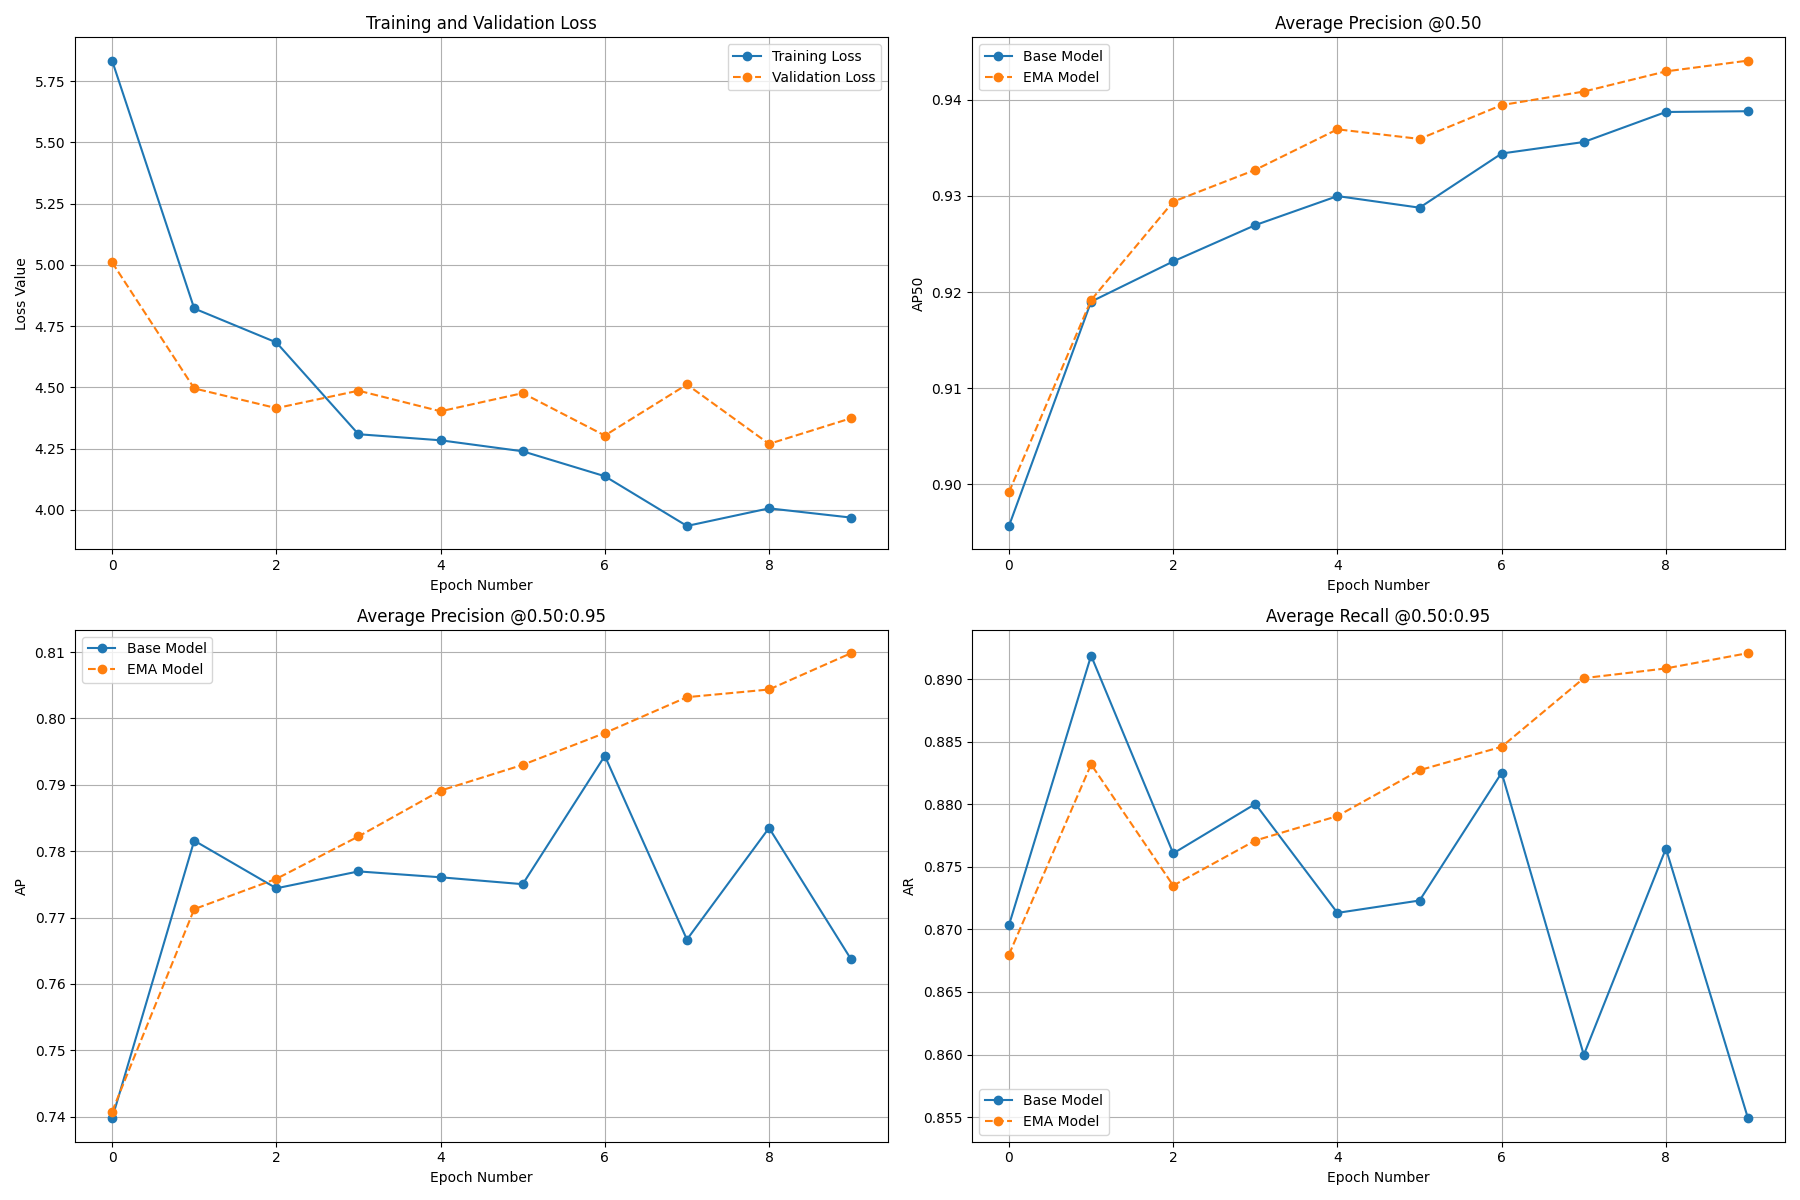

In [14]:
from PIL import Image

Image.open("/content/output/metrics_plot.png")

In [15]:
!ls -la /content/output

total 1962988
drwxr-xr-x 3 root root      4096 Oct 24 10:23 .
drwxr-xr-x 1 root root      4096 Oct 24 07:53 ..
-rw-r--r-- 1 root root 536181077 Oct 24 10:20 checkpoint0009.pth
-rw-r--r-- 1 root root 401229370 Oct 24 10:22 checkpoint_best_ema.pth
-rw-r--r-- 1 root root 402489302 Oct 24 09:36 checkpoint_best_regular.pth
-rw-r--r-- 1 root root 133709167 Oct 24 10:23 checkpoint_best_total.pth
-rw-r--r-- 1 root root 536170885 Oct 24 10:20 checkpoint.pth
drwxr-xr-x 2 root root      4096 Oct 24 08:08 eval
-rw-r--r-- 1 root root      4412 Oct 24 10:22 events.out.tfevents.1761292393.3dc4ed007e96.520.0
-rw-r--r-- 1 root root     75928 Oct 24 10:22 log.txt
-rw-r--r-- 1 root root    196555 Oct 24 10:23 metrics_plot.png
-rw-r--r-- 1 root root      1183 Oct 24 10:23 results.json


In [ ]:
model.deploy_to_roboflow(
  workspace="roboflow-jvuqo",
  project_id="basketball-player-detection-2",
  version=13,
  api_key=os.environ["ROBOFLOW_API_KEY"]
)

In [ ]:
import gc
import torch
import weakref

def cleanup_gpu_memory(obj=None, verbose: bool = False):

    if not torch.cuda.is_available():
        if verbose:
            print("[INFO] CUDA is not available. No GPU cleanup needed.")
        return

    def get_memory_stats():
        allocated = torch.cuda.memory_allocated()
        reserved = torch.cuda.memory_reserved()
        return allocated, reserved

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[Before] Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

    # Ensure we drop all strong references
    if obj is not None:
        ref = weakref.ref(obj)
        del obj
        if ref() is not None and verbose:
            print("[WARNING] Object not fully garbage collected yet.")

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[After]  Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

In [ ]:
cleanup_gpu_memory(model, verbose=True)

[Before] Allocated: 13156.72 MB | Reserved: 14902.00 MB
[WARNING] Object not fully garbage collected yet.
[After]  Allocated: 13156.72 MB | Reserved: 14010.00 MB


In [ ]:
model = RFDETRMedium(pretrain_weights="/content/output/checkpoint_best_total.pth")
model.optimize_for_inference()

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

In [ ]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0)

    targets.append(annotations)
    predictions.append(detections)

In [ ]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()
print(map_result)

In [ ]:
from rfdetr import RFDETRBase
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path)

detections = model.predict(image, threshold=0.5)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
    "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

bbox_annotator = sv.BoxAnnotator(color=color,thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

In [ ]:
!pip install -q inference-gpu==0.51.7

In [ ]:
from inference import get_model

MODEL_ID = "basketball-player-detection-2/13"
model_rf = get_model(model_id=MODEL_ID, api_key = userdata.get("ROBOFLOW_API_KEY"))

In [ ]:
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path)

result = model_rf.infer(image, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
    "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

bbox_annotator = sv.BoxAnnotator(color=color,thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])